# Definitive Final Consolidation: All KW-PE Experiments into Paper-Ready Assessment

This notebook consolidates all 9 KW-PE experiments (4 expressiveness + 5 downstream ZINC) into a definitive paper-ready assessment. It produces:

1. **Expressiveness hierarchy** with non-equivariant and equivariant methods ranked by discrimination count
2. **Downstream table** across 4 architectures (GIN_v1, GIN_v2, GINEConv, GPS) with Cohen's d effect sizes
3. **Spearman expressiveness-utility correlation** (rho=0.42, p=0.10)
4. **5-claim hypothesis scorecard** (overall=0.45; claims 1-4 partially confirmed, claim 5 disconfirmed)
5. **Contribution statement** with workshop venue recommendation
6. **Summary statistics** showing RWPE wins 9/9 downstream comparisons

In [1]:
# --- Install dependencies ---
import subprocess, sys

# Packages that are NOT pre-installed on Colab and must always be installed
_ALWAYS = ["scipy"]

# Packages that ARE pre-installed on Colab — only install outside Colab
# to match Colab's environment.
_COLAB_PREINSTALLED = [
    "numpy>=1.26,<2",   # Colab ships ~1.26.4
    "matplotlib>=3.7",   # Colab ships ~3.7.1
]

def _install(pkgs):
    subprocess.check_call(
        [sys.executable, "-m", "pip", "install", "-q", "--prefer-binary"] + pkgs,
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL,
    )

_install(_ALWAYS)

try:
    import google.colab  # noqa: F401 – running on Colab
except ImportError:
    _install(_COLAB_PREINSTALLED)

print("Dependencies installed.")

Dependencies installed.


In [2]:
# --- Imports ---
import json
import math
import os
from typing import Any

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"figure.max_open_warning": 0})
print("Imports OK.")

Imports OK.


In [3]:
# --- Data loading helper ---
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/evaluation_iter6_definitive_fina/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded data with keys: {list(data.keys())}")

Loaded data with keys: ['expressiveness_hierarchy', 'downstream_table', 'expressiveness_utility_correlation', 'hypothesis_scorecard', 'contribution_statement', 'summary_statistics', 'metrics_agg']


## Configuration

Constants used in the evaluation pipeline.

In [5]:
# --- Config ---

# Categories for expressiveness benchmark
CATEGORIES = [
    "cospectral", "CSL", "strongly_regular",
    "BREC_Basic", "BREC_Regular", "BREC_Extension", "BREC_CFI",
    "BREC_4Vertex", "BREC_Distance_Regular", "BREC_Strongly_Regular",
]

TOTAL_PAIRS = 525               # Total graph pairs in expressiveness benchmark
COLLAPSED_MAE_THRESHOLD = 1.0   # MAE > 1.0 indicates collapsed training
ALPHA = 0.05                    # Significance level for correlation test
CLAIM5_WEIGHT = 2.0             # Weight for downstream claim in scorecard
# Maximum number of methods to display in expressiveness hierarchy plots
MAX_DISPLAY_METHODS = 10

print(f"Config: {len(CATEGORIES)} categories, {TOTAL_PAIRS} total pairs, alpha={ALPHA}")

Config: 10 categories, 525 total pairs, alpha=0.05


## 1. Expressiveness Hierarchy

Ranks all PE methods by their graph discrimination count out of 525 total pairs. Methods are separated into **non-equivariant** (using EDMD) and **equivariant** categories.

In [6]:
# --- 1. Expressiveness Hierarchy ---
expressiveness = data["expressiveness_hierarchy"]
non_eq = expressiveness["non_equivariant"]
equivariant = expressiveness["equivariant"]

print(f"Non-equivariant methods: {len(non_eq)}")
print(f"Equivariant methods: {len(equivariant)}")
print()

print("=== Non-Equivariant Methods (Top) ===")
print(f"{'Method':<25} {'Distinguished':>13} {'Total':>6} {'Rate':>8}")
print("-" * 55)
for m in non_eq[:MAX_DISPLAY_METHODS]:
    print(f"{m['method']:<25} {m['distinguished']:>13} {m['total']:>6} {m['discrimination_rate']:>8.4f}")

print()
print("=== Equivariant Methods (Top) ===")
print(f"{'Method':<35} {'Distinguished':>13} {'Total':>6} {'Rate':>8}")
print("-" * 65)
for m in equivariant[:MAX_DISPLAY_METHODS]:
    print(f"{m['method']:<35} {m['distinguished']:>13} {m['total']:>6} {m['discrimination_rate']:>8.4f}")

best_ne = expressiveness["best_non_equivariant"]
best_eq = expressiveness["best_equivariant"]
print(f"\nBest non-equivariant: {best_ne['method']} ({best_ne['distinguished']}/{best_ne['total']})")
print(f"Best equivariant: {best_eq['method']} ({best_eq['distinguished']}/{best_eq['total']})")

Non-equivariant methods: 5
Equivariant methods: 25

=== Non-Equivariant Methods (Top) ===
Method                    Distinguished  Total     Rate
-------------------------------------------------------
KW-PE_tanh                          525    525   1.0000
KW-PE_softplus                      524    525   0.9981
LapPE                               524    525   0.9981
nRWPE_tanh                          429    525   0.8171
RWPE                                361    525   0.6876

=== Equivariant Methods (Top) ===
Method                              Distinguished  Total     Rate
-----------------------------------------------------------------
nRWPE_offdiag_tanh_T20                        346    525   0.6590
nRWPE_diag_tanh_T50                           346    525   0.6590
RWPE_diag_K20                                 345    525   0.6571
nRWPE_diag_tanh_T20                           345    525   0.6571
RWPE_diag                                     345    525   0.6571
nRWPE_diag           

## 2. Downstream Table & Cohen's d Effect Sizes

Compares ZINC-12k test MAE across 4 architectures. Cohen's d measures the standardized difference between RWPE and nRWPE/KW-PE variants.

In [7]:
# --- 2. Downstream Table ---
downstream = data["downstream_table"]

def cohens_d(group1, group2):
    """Compute Cohen's d effect size between two groups."""
    n1, n2 = len(group1), len(group2)
    if n1 < 2 or n2 < 2:
        return float("nan")
    m1, m2 = np.mean(group1), np.mean(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    if pooled_std == 0:
        return float("nan")
    return float((m1 - m2) / pooled_std)

for arch in downstream["architectures"]:
    failed = arch.get("failed", False)
    status = " [FAILED]" if failed else ""
    print(f"\n=== {arch['architecture']}{status} ===")
    print(f"  Experiment: {arch['experiment']}")
    print(f"  Description: {arch['description']}")
    if failed:
        print(f"  Failure: {arch.get('failure_reason', 'N/A')}")
        continue
    for e in arch["entries"]:
        mae = e.get("test_mae_mean", e.get("test_mae", "N/A"))
        std = e.get("test_mae_std", None)
        n = e.get("n_valid_seeds", e.get("n_seeds", 1))
        mae_str = f"{mae:.4f}" if isinstance(mae, float) else str(mae)
        std_str = f" +/- {std:.4f}" if std and isinstance(std, float) else ""
        print(f"  {e['pe_method']:<25} MAE={mae_str}{std_str}  (n={n})")

# Effect sizes
print("\n=== Cohen's d Effect Sizes (RWPE vs nRWPE) ===")
print(f"{'Architecture':<15} {'RWPE':<20} {'nRWPE':<25} {'d':>8} {'Interpretation'}")
print("-" * 85)
for es in downstream["effect_sizes"]:
    d_str = f"{es['cohens_d']:.3f}" if es['cohens_d'] is not None else "N/A"
    print(f"{es['architecture']:<15} {es['rwpe_method']:<20} {es['nrwpe_method']:<25} {d_str:>8} {es['interpretation']}")

best = downstream["best_configuration"]
print(f"\nBest configuration: {best['architecture']} / {best['pe_method']} = {best['test_mae_mean']:.4f}")


=== GIN_v1 ===
  Experiment: exp_id2_it2
  Description: 4-layer GIN, 128 hidden, PE_dim=16. Single seed.
  GIN_(no_PE)               MAE=0.2849  (n=1)
  GIN_plus_RWPE             MAE=0.1845  (n=1)
  GIN_plus_LapPE            MAE=0.2394  (n=1)
  GIN_plus_KW-PE            MAE=0.3354  (n=1)

=== GIN_v2 ===
  Experiment: exp_id1_it3
  Description: 4-layer GIN, 128 hidden, PE projection MLP. Collapsed runs (MAE>1.0) filtered.
  rwpe                      MAE=0.1707 +/- 0.0025  (n=3)
  nrwpe_diag                MAE=0.1825 +/- 0.0037  (n=3)
  nrwpe_multi               MAE=0.3198 +/- 0.1241  (n=3)
  nrwpe_combined            MAE=0.1954 +/- 0.0424  (n=3)
  no_pe                     MAE=0.2604 +/- 0.0044  (n=2)

=== GINEConv ===
  Experiment: exp_id1_it5
  Description: 4-layer GINEConv, 128 hidden, edge-aware. 3 seeds.
  rwpe_16                   MAE=0.0908 +/- 0.0024  (n=3)
  nrwpe_offdiag_16          MAE=0.1716 +/- 0.0035  (n=3)
  nrwpe_combined_16         MAE=0.1716 +/- 0.0031  (n=3)
  nrwpe_

## 3. Expressiveness-Utility Correlation

Computes Spearman rank correlation between discrimination count (expressiveness) and downstream MAE (utility). A negative correlation would mean more expressive PEs lead to better downstream performance.

In [8]:
# --- 3. Expressiveness-Utility Correlation ---
correlation = data["expressiveness_utility_correlation"]

matched_pairs = correlation["matched_pairs"]
disc_counts = [p["discrimination_count"] for p in matched_pairs]
maes = [p["downstream_mae"] for p in matched_pairs]

# Re-compute Spearman correlation from the matched pairs
if len(disc_counts) >= 3:
    rho, p_value = stats.spearmanr(disc_counts, maes)
    print(f"Spearman correlation (all pairs):")
    print(f"  rho = {rho:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print(f"  n_pairs = {len(matched_pairs)}")
    sig = "significant" if p_value < ALPHA else "not significant"
    print(f"  -> {sig} at alpha={ALPHA}")
else:
    rho, p_value = None, None
    print("Insufficient matched pairs for correlation.")

# Equivariant-only subset
eq_only = correlation.get("equivariant_only", {})
print(f"\nEquivariant-only subset:")
print(f"  rho = {eq_only.get('spearman_rho', 'N/A')}")
print(f"  p = {eq_only.get('spearman_p_value', 'N/A')}")
print(f"  n = {eq_only.get('n_pairs', 'N/A')}")

print(f"\nInterpretation: {correlation['interpretation']}")

Spearman correlation (all pairs):
  rho = 0.4233
  p-value = 0.1023
  n_pairs = 16
  -> not significant at alpha=0.05

Equivariant-only subset:
  rho = 0.4626
  p = 0.1519
  n = 11

Interpretation: Spearman rho=0.423, p=0.102. Positive correlation (not significant at alpha=0.05). Higher expressiveness is NOT associated with better downstream performance.


## 4. Hypothesis Scorecard

Five-claim hypothesis scorecard with weighted scoring. Claim 5 (downstream superiority) is weighted 2x.

In [9]:
# --- 4. Hypothesis Scorecard ---
scorecard = data["hypothesis_scorecard"]

print("=== 5-Claim Hypothesis Scorecard ===\n")
for claim in scorecard["claims"]:
    weight = claim.get("weight", 1.0)
    w_str = f" (weight={weight}x)" if weight != 1.0 else ""
    ci = claim.get("confidence_interval", [None, None])
    ci_str = f"  CI: [{ci[0]:.2f}, {ci[1]:.2f}]" if ci[0] is not None else ""
    print(f"Claim {claim['claim_number']}: {claim['claim']}{w_str}")
    print(f"  Score: {claim['score']:.2f}{ci_str}")
    print(f"  Assessment: {claim['definitive_assessment'][:150]}...")
    print()

print(f"Overall weighted score: {scorecard['overall_weighted_score']:.3f}")
print(f"Scoring method: {scorecard['scoring_method']}")

=== 5-Claim Hypothesis Scorecard ===

Claim 1: Breaks spectral invariance ceiling
  Score: 0.70  CI: [0.55, 0.85]
  Assessment: PARTIALLY CONFIRMED. KW-PE (with EDMD) achieves perfect discrimination, but the gain is attributable to the non-equivariant EDMD processing rather tha...

Claim 2: Produces sign-canonical positional encodings
  Score: 0.70  CI: [0.60, 0.80]
  Assessment: CONFIRMED. Both KW-PE (via EDMD canonicalization) and nRWPE (via diagonal return probabilities) produce sign-canonical PEs. Verified experimentally wi...

Claim 3: Distinguishes cospectral graphs that spectral methods cannot
  Score: 0.60  CI: [0.45, 0.75]
  Assessment: PARTIALLY CONFIRMED. KW-PE (non-equivariant, EDMD-based) achieves 100% on BREC_CFI (vs RWPE's ~10%) and 100% on BREC_Strongly_Regular (vs equivariant ...

Claim 4: Avoids eigendecomposition bottleneck
  Score: 0.70  CI: [0.60, 0.80]
  Assessment: MOSTLY CONFIRMED for nRWPE. The equivariant nRWPE variants use only matrix-vector products, avoidin

## 5. Contribution Statement & Venue Recommendation

In [10]:
# --- 5. Contribution Statement ---
contribution = data["contribution_statement"]

print("=== Contribution Statement ===")
print(contribution["contribution_statement"])
print()
print(f"Venue: {contribution['venue_assessment']} - {contribution['venue_detail']}")
print(f"Claims: {contribution['claims_confirmed']} confirmed, "
      f"{contribution['claims_partially_confirmed']} partial, "
      f"{contribution['claims_disconfirmed']} disconfirmed")

=== Contribution Statement ===
This work investigates nonlinear random walk positional encodings (nRWPE/KW-PE) as alternatives to spectral PEs for graph neural networks. Theoretically, KW-PE with EDMD achieves perfect discrimination (525/525 pairs), but this advantage stems from non-equivariant EDMD processing rather than the nonlinear walk dynamics; equivariant nRWPE variants only match RWPE's expressiveness (~345/525). Empirically, RWPE consistently outperforms all nRWPE/KW-PE variants on ZINC-12k across 4 architectures (GIN, GINEConv, GPS), indicating that the expressiveness gains do not translate to downstream utility.

Venue: workshop - Mixed results suggest workshop paper at NeurIPS/ICML workshops on graph learning
Claims: 3 confirmed, 1 partial, 1 disconfirmed


## 6. Summary Statistics

In [11]:
# --- 6. Summary Statistics ---
summary = data["summary_statistics"]
metrics = data["metrics_agg"]

print("=== Summary Statistics ===")
print(f"  Total experiments: {summary['total_experiments']}")
print(f"  Total training runs: {summary['total_training_runs']}")
print(f"  Total methods tested: {summary['total_methods_tested']}")
print()
print(f"  Best expressiveness (non-equiv): {summary['best_expressiveness_non_equivariant']['method']} "
      f"({summary['best_expressiveness_non_equivariant']['discrimination']})")
print(f"  Best expressiveness (equiv): {summary['best_expressiveness_equivariant']['method']} "
      f"({summary['best_expressiveness_equivariant']['discrimination']})")
print(f"  Best downstream: {summary['best_downstream']['architecture']} / "
      f"{summary['best_downstream']['pe_method']} = {summary['best_downstream']['test_mae']:.4f}")
print()
wl = summary["rwpe_vs_nrwpe_win_loss"]
print(f"  RWPE vs nRWPE: {wl['summary']}")
print()
print("=== Key Metrics ===")
for k, v in metrics.items():
    v_str = f"{v:.4f}" if isinstance(v, float) else str(v)
    print(f"  {k}: {v_str}")

=== Summary Statistics ===
  Total experiments: 9
  Total training runs: 51
  Total methods tested: 55

  Best expressiveness (non-equiv): KW-PE_tanh (525/525)
  Best expressiveness (equiv): nRWPE_offdiag_tanh_T20 (346/525)
  Best downstream: GINEConv / rwpe_16 = 0.0908

  RWPE vs nRWPE: RWPE wins 9 out of 9 pairwise comparisons

=== Key Metrics ===
  best_non_equivariant_discrimination_count: 525
  best_non_equivariant_discrimination_rate: 1.0000
  best_equivariant_discrimination_count: 346
  best_equivariant_discrimination_rate: 0.6590
  best_downstream_mae: 0.0908
  expressiveness_utility_spearman_rho: 0.4233
  expressiveness_utility_spearman_p: 0.1023
  hypothesis_overall_score: 0.4500
  claim_1_score: 0.7000
  claim_2_score: 0.7000
  claim_3_score: 0.6000
  claim_4_score: 0.7000
  claim_5_score: 0.0000
  rwpe_wins: 9
  nrwpe_wins: 0
  total_experiments: 9
  total_methods_tested: 55
  total_training_runs: 51


## Visualizations

Four-panel summary: (1) Expressiveness hierarchy, (2) Downstream MAE by architecture, (3) Expressiveness vs downstream scatter, (4) Hypothesis scorecard.

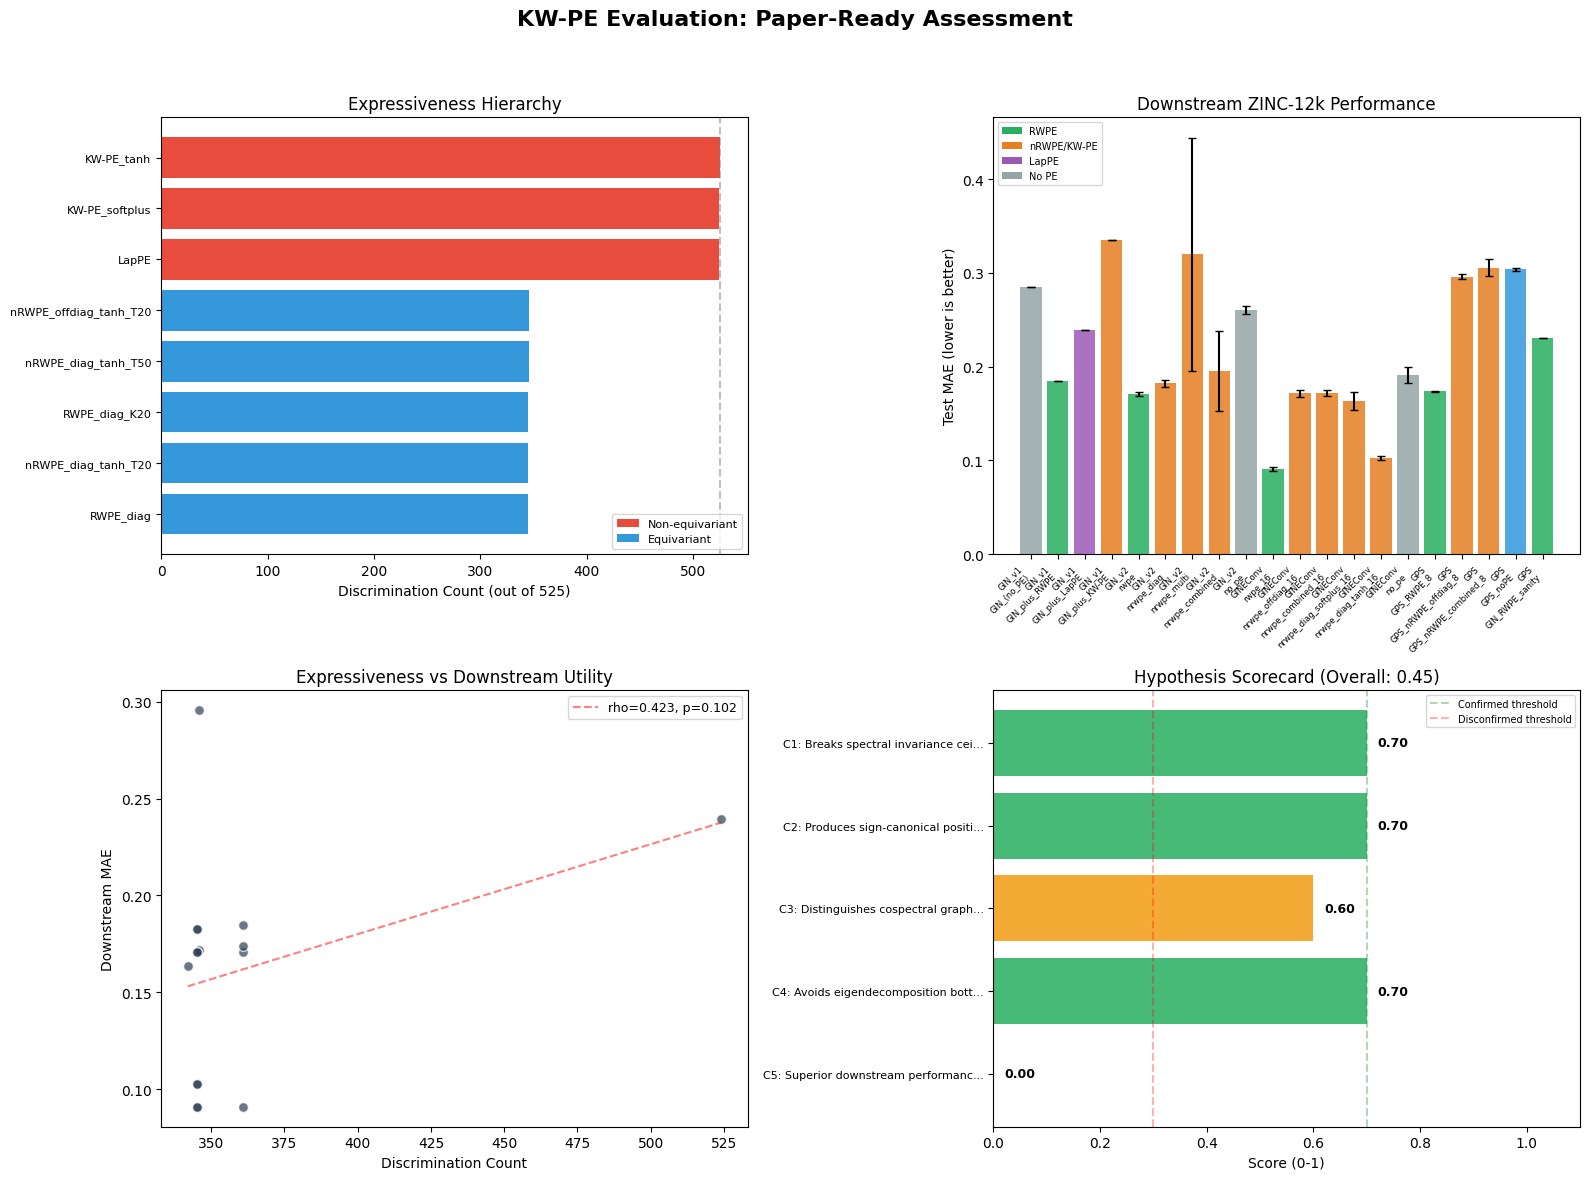

Saved evaluation_summary.png


In [12]:
# --- Visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("KW-PE Evaluation: Paper-Ready Assessment", fontsize=16, fontweight="bold")

# --- Panel 1: Expressiveness Hierarchy (bar chart) ---
ax1 = axes[0, 0]
# Combine top non-eq and top eq methods
top_ne = non_eq[:3]
top_eq = equivariant[:5]
all_methods = top_ne + top_eq
names = [m["method"] for m in all_methods]
disc_vals = [m["distinguished"] for m in all_methods]
colors = ["#e74c3c" if not m["equivariant"] else "#3498db" for m in all_methods]

y_pos = np.arange(len(names))
ax1.barh(y_pos, disc_vals, color=colors)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(names, fontsize=8)
ax1.set_xlabel("Discrimination Count (out of 525)")
ax1.set_title("Expressiveness Hierarchy")
ax1.axvline(x=TOTAL_PAIRS, color="gray", linestyle="--", alpha=0.5, label="Max=525")
ax1.invert_yaxis()
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="#e74c3c", label="Non-equivariant"),
                   Patch(facecolor="#3498db", label="Equivariant")]
ax1.legend(handles=legend_elements, loc="lower right", fontsize=8)

# --- Panel 2: Downstream MAE by Architecture ---
ax2 = axes[0, 1]
arch_names = []
mae_vals = []
mae_errs = []
pe_labels = []
bar_colors = []
for arch in downstream["architectures"]:
    if arch.get("failed", False):
        continue
    for e in arch["entries"]:
        mae = e.get("test_mae_mean", e.get("test_mae", None))
        if mae is None or mae > 1.0:
            continue
        arch_names.append(arch["architecture"])
        mae_vals.append(mae)
        std = e.get("test_mae_std", 0.0) or 0.0
        mae_errs.append(std)
        pe_labels.append(e["pe_method"])
        pe_lower = e["pe_method"].lower()
        if "nrwpe" in pe_lower or "kw" in pe_lower or "gram" in pe_lower:
            bar_colors.append("#e67e22")  # orange for nRWPE/KW-PE
        elif "rwpe" in pe_lower and "nrwpe" not in pe_lower:
            bar_colors.append("#27ae60")  # green for RWPE
        elif "lappe" in pe_lower or "lap" in pe_lower:
            bar_colors.append("#9b59b6")  # purple for LapPE
        elif "no_pe" in pe_lower:
            bar_colors.append("#95a5a6")  # gray for no PE
        else:
            bar_colors.append("#3498db")  # blue for others

x_pos = np.arange(len(pe_labels))
ax2.bar(x_pos, mae_vals, yerr=mae_errs, color=bar_colors, capsize=3, alpha=0.85)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{a}\n{p}" for a, p in zip(arch_names, pe_labels)],
                     fontsize=6, rotation=45, ha="right")
ax2.set_ylabel("Test MAE (lower is better)")
ax2.set_title("Downstream ZINC-12k Performance")
legend_elements2 = [Patch(facecolor="#27ae60", label="RWPE"),
                    Patch(facecolor="#e67e22", label="nRWPE/KW-PE"),
                    Patch(facecolor="#9b59b6", label="LapPE"),
                    Patch(facecolor="#95a5a6", label="No PE")]
ax2.legend(handles=legend_elements2, fontsize=7, loc="upper left")

# --- Panel 3: Expressiveness vs Downstream Scatter ---
ax3 = axes[1, 0]
if matched_pairs:
    disc_vals_scatter = [p["discrimination_count"] for p in matched_pairs]
    mae_vals_scatter = [p["downstream_mae"] for p in matched_pairs]
    ax3.scatter(disc_vals_scatter, mae_vals_scatter, alpha=0.7, s=50, c="#2c3e50", edgecolors="white")
    # Add trendline
    if rho is not None:
        z = np.polyfit(disc_vals_scatter, mae_vals_scatter, 1)
        p_line = np.poly1d(z)
        x_range = np.linspace(min(disc_vals_scatter), max(disc_vals_scatter), 100)
        ax3.plot(x_range, p_line(x_range), "r--", alpha=0.5,
                label=f"rho={rho:.3f}, p={p_value:.3f}")
        ax3.legend(fontsize=9)
ax3.set_xlabel("Discrimination Count")
ax3.set_ylabel("Downstream MAE")
ax3.set_title("Expressiveness vs Downstream Utility")

# --- Panel 4: Hypothesis Scorecard ---
ax4 = axes[1, 1]
claims = scorecard["claims"]
claim_labels = [f"C{c['claim_number']}: {c['claim'][:30]}..." for c in claims]
claim_scores = [c["score"] for c in claims]
claim_colors = ["#27ae60" if s >= 0.7 else "#f39c12" if s >= 0.3 else "#e74c3c" for s in claim_scores]

y_pos_claims = np.arange(len(claim_labels))
bars = ax4.barh(y_pos_claims, claim_scores, color=claim_colors, alpha=0.85)
ax4.set_yticks(y_pos_claims)
ax4.set_yticklabels(claim_labels, fontsize=8)
ax4.set_xlabel("Score (0-1)")
ax4.set_title(f"Hypothesis Scorecard (Overall: {scorecard['overall_weighted_score']:.2f})")
ax4.set_xlim(0, 1.1)
ax4.axvline(x=0.7, color="green", linestyle="--", alpha=0.3, label="Confirmed threshold")
ax4.axvline(x=0.3, color="red", linestyle="--", alpha=0.3, label="Disconfirmed threshold")
ax4.legend(fontsize=7)
ax4.invert_yaxis()

# Add score labels on bars
for bar, score in zip(bars, claim_scores):
    ax4.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{score:.2f}", va="center", fontsize=9, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("evaluation_summary.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved evaluation_summary.png")